In [62]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.losses import MeanSquaredLogarithmicError,MeanSquaredError,MeanAbsolutePercentageError,Huber
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [63]:
def pasar_a_datetime(fecha):
    #format_string = '%Y-%m-%d'
    anio,mes,dia= fecha.split('-')
    aux_dia = dia.split(' ')
    if len(aux_dia)>1:dia = aux_dia[0]
    res = datetime(int(anio),int(mes),int(dia))
    return res

In [64]:
def scale_datasets(x_train, x_test):
    #min_max = MinMaxScaler ()
    stdscaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        stdscaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        stdscaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled,stdscaler

In [65]:
def convertData_m(datax,datay,step):
    sequences = []
    target_labels = []

    for i in range(len(datax) - step + 1):
        sequences.append(datax[i:i + step])
        target_labels.append(datay.iloc[i + step - 1])
    X = np.array(sequences)
    y = np.array(target_labels)
    return X,y

In [66]:
def convertData(datax,datay,step):
    sequences = []
    target_labels = []

    for i in range(len(datax) - step + 1):
        sequences.append(datax.iloc[i:i + step])
        target_labels.append(datay.iloc[i + step - 1])
    X = np.array(sequences)
    y = np.array(target_labels)
    return X,y

In [67]:
def ordenar_fecha(data):
    data['fecha_mediana'] = data['fecha_mediana'].map(lambda x: pasar_a_datetime(x))
    data.sort_values(by='fecha_mediana',inplace=True)

In [68]:
def preparar_datos_entrenamiento(X_train, X_test):
    x_train_scaled, x_test_scaled,stdscaler = scale_datasets(X_train, X_test)
    # testx,testy = convertData(x_test_scaled,y_test, step)
    # trainx,trainy = convertData(x_train_scaled,y_train, step)
    #trainx = trainx.reshape(trainx.shape[0], step, trainx.shape[2])

    # return trainx,trainy,testx,testy,stdscaler
    return x_train_scaled, x_test_scaled,stdscaler 

In [69]:
def spliteo_data(datos, split_training):
    cols = datos.columns.to_list()
    idx = cols.index('Fuente')
    x_cols = cols[:idx+1]+cols[-2:]
    y_cols = cols[idx+2:-2]

    x = datos.loc[:,x_cols]
    y = datos.loc[:,y_cols]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split_training,shuffle=True,random_state=2023)
    
    return X_train, X_test, y_train, y_test,x_cols,y_cols

In [12]:
data_primera_vuelta = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_primera_vuelta.csv')
data_solo_ballotaje = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_solo_ballotaje.csv')
data_encuestas_poly = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_encuestas_poly.csv')
data_ballotaje_poly = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_ballotaje_poly.csv')

In [10]:
ordenar_fecha(data_primera_vuelta)
ordenar_fecha(data_solo_ballotaje)
ordenar_fecha(data_encuestas_poly)
ordenar_fecha(data_ballotaje_poly)

In [70]:
def modelo_arquitectura(in_dim,out_dim,learning_rate):
    metrica = RootMeanSquaredError()
    perdida = MeanSquaredError()

    model = Sequential()
    model.add(Dense(units=in_dim,input_dim=in_dim,activation='softplus'))
    model.add(Dense(units=3,activation='softplus'))
    model.add(Dense(units=out_dim, activation='softplus')) 
    model.compile(loss=perdida, 
                optimizer=SGD(learning_rate=learning_rate,
                              momentum=0.8), 
                metrics=[metrica]) 
    
    return model

In [71]:
data_ballotaje_poly.columns

Index(['La Libertad Avanza', 'Union por la Patria', 'Fuente', 'fecha_mediana',
       'La Libertad Avanza_Encuestas', 'Union por la Patria_Encuestas', 'dia',
       'mes'],
      dtype='object')

In [73]:
def entrenarRNN(datos, split_training, learning_rate,ciclos):
    
    X_train, X_test, y_train, y_test,x_cols,y_cols = spliteo_data(datos, split_training)
    
    x_train_scaled, x_test_scaled,stdscaler = preparar_datos_entrenamiento(X_train, X_test)

    in_dim=X_train.shape[-1]
    out_dim=y_train.shape[1]
    
    
    model = modelo_arquitectura(in_dim, out_dim,learning_rate)

    history = model.fit(x_train_scaled,y_train, epochs=ciclos, verbose=1,batch_size=16)
    
    
    #GRAFIQUEMOS
    nro_partidos=5
    fig, ax = plt.subplots(nro_partidos,1,figsize=(12,5*nro_partidos))
    x = datos.loc[:,x_cols]
    y = datos.loc[:,y_cols]
    x_scaled = stdscaler.transform(x)
    predicted = model.predict(x_scaled)
    
    xlen = np.arange(len(x))
    for i,a in enumerate(ax.flatten()):
        a.scatter(xlen, predicted[:,i],  label="Predicho",color="purple",s=5)
        a.scatter(xlen, y.iloc[:,i],label="Esperado",color='green',s=10)
    plt.legend()
    return model
    

Epoch 1/300
75/75 [==============================] - 1s 3ms/step - loss: 69.1386 - root_mean_squared_error: 8.3150
Epoch 2/300
75/75 [==============================] - 0s 3ms/step - loss: 4.0373 - root_mean_squared_error: 2.0093
Epoch 3/300
75/75 [==============================] - 0s 5ms/step - loss: 2.4136 - root_mean_squared_error: 1.5536
Epoch 4/300
75/75 [==============================] - 0s 5ms/step - loss: 2.2454 - root_mean_squared_error: 1.4985
Epoch 5/300
75/75 [==============================] - 0s 4ms/step - loss: 2.1642 - root_mean_squared_error: 1.4711
Epoch 6/300
75/75 [==============================] - 0s 4ms/step - loss: 1.9912 - root_mean_squared_error: 1.4111
Epoch 7/300
75/75 [==============================] - 0s 4ms/step - loss: 1.8738 - root_mean_squared_error: 1.3689
Epoch 8/300
75/75 [==============================] - 0s 3ms/step - loss: 1.8328 - root_mean_squared_error: 1.3538
Epoch 9/300
75/75 [==============================] - 0s 6ms/step - loss: 1.8139 - root_

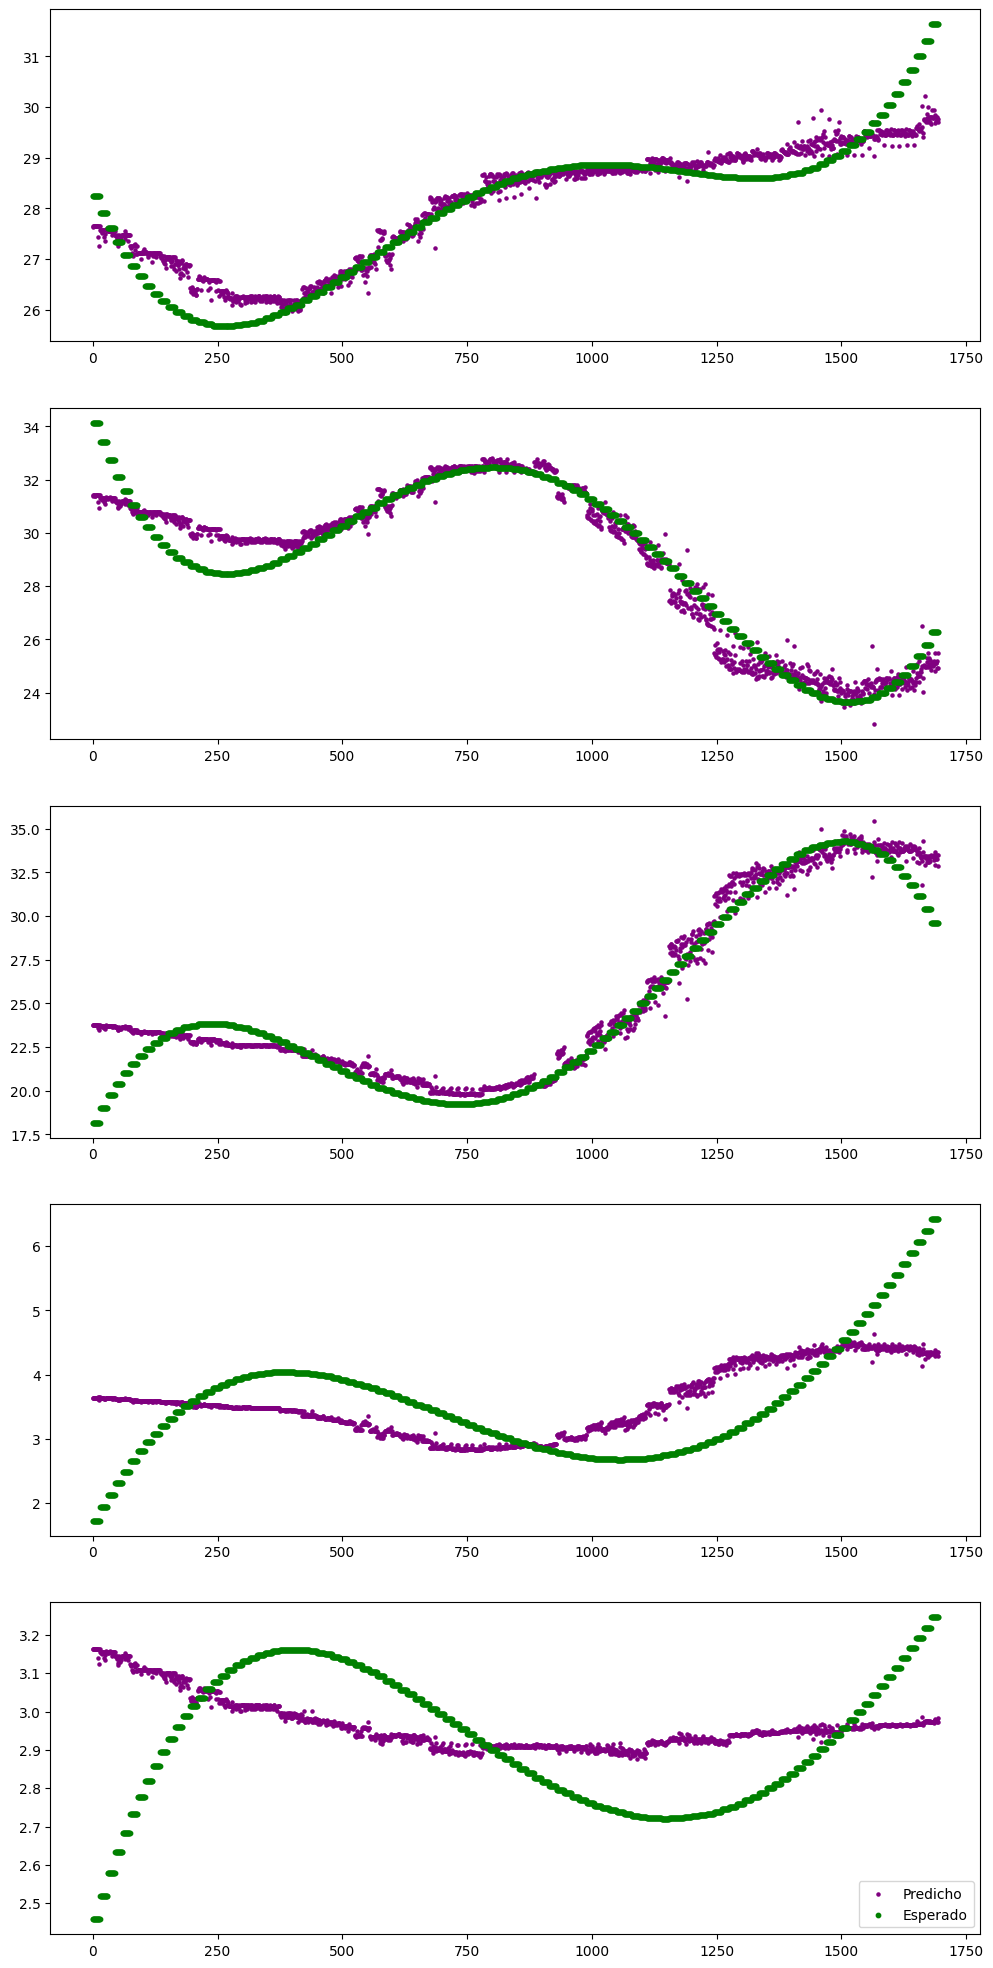

In [75]:
model= entrenarRNN(data_encuestas_poly,0.3,0.005,300)

# Buscando los mejores parametros

In [15]:
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasRegressor

In [16]:
def buildModel(learning_rate=0.05,dropout_rate=0.2):
    metrica = RootMeanSquaredError()
    perdida = MeanSquaredError()

    model = Sequential()
    model.add(Dense(units=8,input_dim=8,activation='softplus'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=6,activation='softplus'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=5, activation='softplus')) 
    model.compile(loss=perdida, 
                optimizer=SGD(learning_rate=learning_rate,
                              momentum=0.8), 
                metrics=[metrica]) 
    #model.summary()
    return model

In [17]:
X_train, X_test, y_train, y_test,x_cols,y_cols = spliteo_data(data_encuestas_poly, 0.3)
x_train_scaled, x_test_scaled,stdscaler=preparar_datos_entrenamiento(X_train, X_test)

model_keras = KerasRegressor(model=buildModel, verbose=0)

batch_size = [16]
epochs =    [300]
learn_rate = [0.05]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#activation = ['softplus']

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#batch_size=batch_size,optimizer=optimizer,optimizer__learning_rate=learn_rate,model__activation=activation

param_grid = dict(epochs=epochs,optimizer__learning_rate=learn_rate,batch_size=batch_size,model__dropout_rate=dropout_rates)
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=-1, cv=3,verbose=3,scoring='neg_root_mean_squared_error')
grid_result = grid.fit(x_train_scaled, y_train)
grid_result.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Graficos

In [52]:
drop_out = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/data_Grid_search/data_drop_out_rate.csv')
grid_activation_function = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/data_Grid_search/data_grid_activation_function.csv')
grid_bacht_size = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/data_Grid_search/data_grid_bacht_size.csv')
grid_epochs_learning = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/data_Grid_search/data_grid_epochs_learning_rate.csv')

Text(0.5, 0, '')

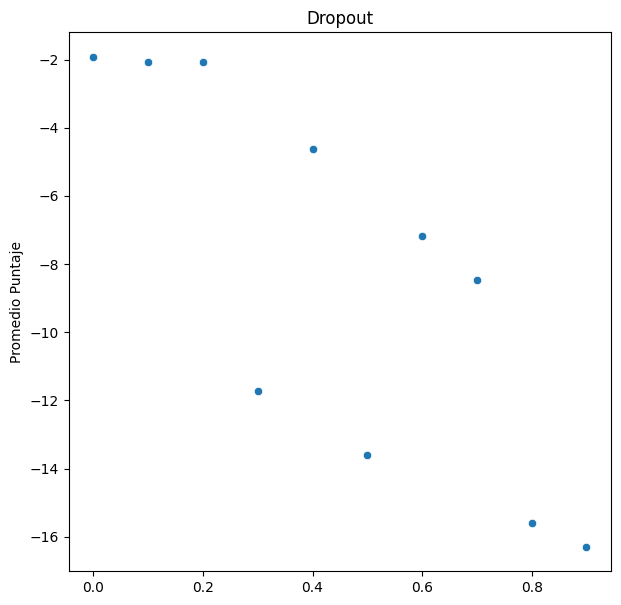

In [61]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=drop_out,x='param_model__dropout_rate',y='mean_test_score')
plt.title('Dropout')
plt.ylabel('Promedio Puntaje')
plt.xlabel('')

Text(0.5, 1.0, 'Función de activación')

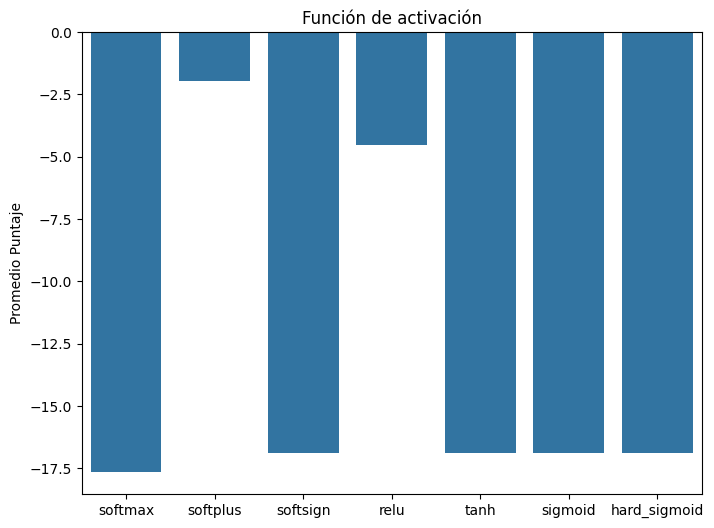

In [60]:
plt.figure(figsize=(8,6))
sns.barplot(data=grid_activation_function.dropna(),x='param_model__activation',y='mean_test_score')
plt.xlabel('')
plt.ylabel('Promedio Puntaje')
plt.title('Función de activación')

In [16]:
grid_bacht_size['mean_fit_time'] = grid_bacht_size['mean_fit_time'].map(lambda x: round(x,2))

In [53]:
h='Promedio tiempo p/ entrenar(s)'
grid_bacht_size.rename(columns={'mean_fit_time':h},inplace=True)

Text(0.5, 0, 'Batch size')

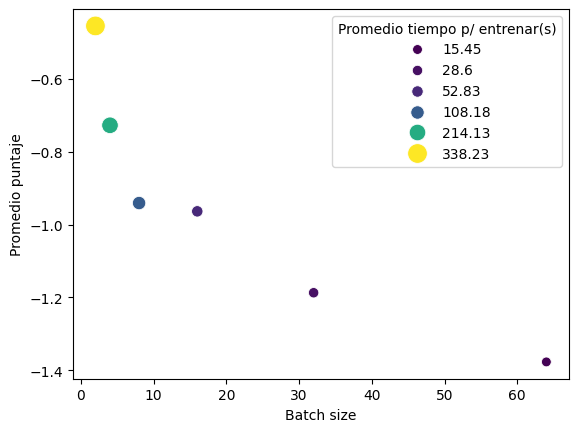

In [54]:
grid_bacht_size[h] = grid_bacht_size[h].map(lambda x:round(x,2))
sns.scatterplot(data=grid_bacht_size,x='param_batch_size',y='mean_test_score',hue=h,
                size=h,palette='viridis',sizes=(50, 200))
plt.ylabel('Promedio puntaje')
plt.xlabel('Batch size')

In [18]:
filtro = grid_epochs_learning['mean_test_score'].quantile(0.2)

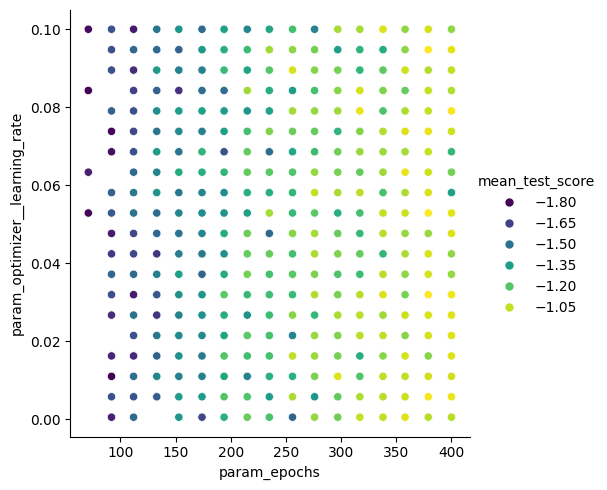

In [19]:
sns.relplot(data = grid_epochs_learning[grid_epochs_learning['mean_test_score']>filtro], x = 'param_epochs', y = 'param_optimizer__learning_rate',hue='mean_test_score',palette='viridis')

Text(-2.3055555555555554, 0.5, 'Promedio Puntaje')

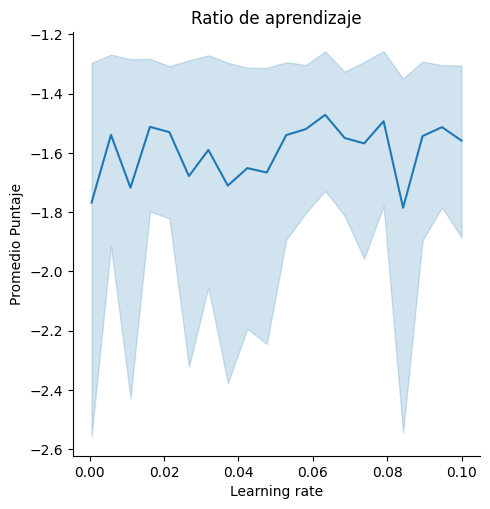

In [33]:
sns.relplot(data=grid_epochs_learning,kind='line',x='param_optimizer__learning_rate',y='mean_test_score')
plt.title('Ratio de aprendizaje')
plt.xlabel('Learning rate')
plt.ylabel('Promedio Puntaje')

Text(10.944444444444445, 0.5, 'Promedio Puntaje')

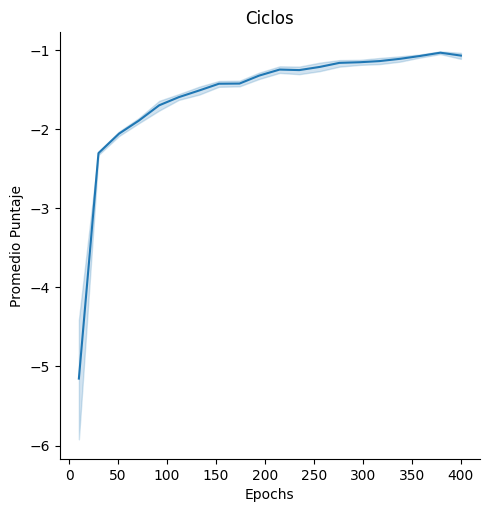

In [34]:
sns.relplot(data=grid_epochs_learning,kind='line',x='param_epochs',y='mean_test_score')
plt.title('Ciclos')
plt.xlabel('Epochs')
plt.ylabel('Promedio Puntaje')